In [91]:
!pip install dash

In [92]:
pip install --upgrade pip


In [93]:
!pip install torch

In [94]:
import pandas as pd
import numpy as np
import dash

import torch
import torch.nn as nn
import torch.optim as optim

import plotly.express as px

from dash import html
from dash import dcc
from dash.dependencies import Input, Output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

In [95]:
df = pd.read_csv('student.csv')

# Nettoyage

In [97]:

df = df.drop(columns=['Unnamed'], errors='ignore')

In [98]:
df.head()

,Unnamed: 0,Id,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,0,5001,21,Male,Other,50%,Yes,No,Private,0.0,Always,Yes,Yes,No,No,AA
1,1,5002,20,Male,Other,50%,Yes,No,Private,0.0,Always,Yes,No,Yes,Yes,AA
2,2,5003,21,Male,State,50%,No,No,Private,2.0,Never,No,No,No,Yes,AA
3,3,5004,18,Female,Private,50%,Yes,No,Bus,2.0,Always,No,Yes,No,No,AA
4,4,5005,22,Male,Private,50%,No,No,Bus,12.0,Always,Yes,No,Yes,Yes,AA


In [99]:
# Supprimer la première colonne du DataFrame
df = df.drop(df.columns[0], axis=1)


# Drop dublicates

In [100]:
df = df.drop_duplicates()

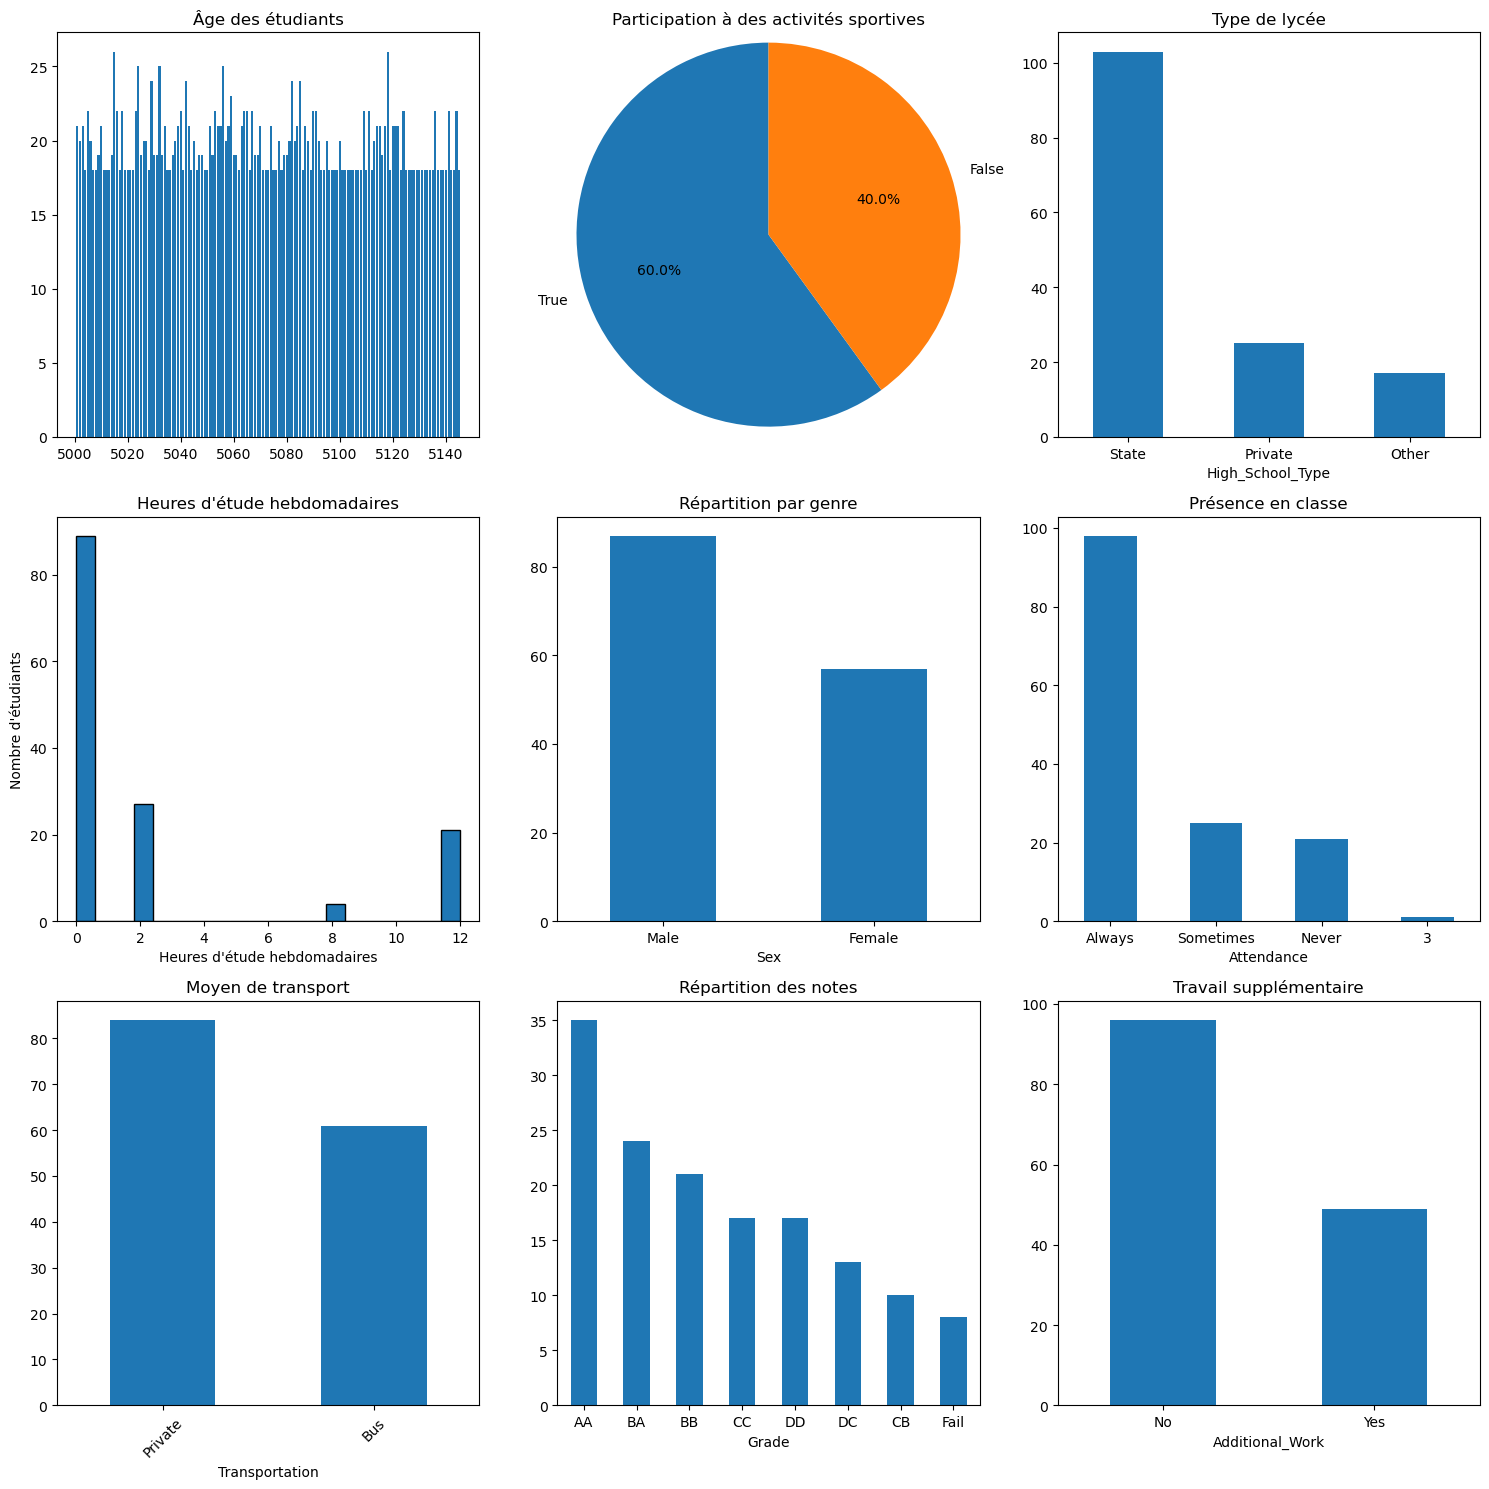

In [101]:
# Visualisation des données
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
 
# Diagramme en barres pour l'âge des étudiants
axes[0, 0].bar(df['Id'], df['Student_Age'])
axes[0, 0].set_title('Âge des étudiants')
 
# Diagramme circulaire pour l'activité sportive
labels = ['True', 'False']
sizes = df['Sports_activity'].value_counts()
axes[0, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].axis('equal')
axes[0, 1].set_title('Participation à des activités sportives')
 
# Diagramme en barres pour le type de lycée
df['High_School_Type'].value_counts().plot(kind='bar', ax=axes[0, 2], rot=0)
axes[0, 2].set_title('Type de lycée')
 
# Histogramme pour les heures d'étude hebdomadaires
axes[1, 0].hist(df['Weekly_Study_Hours'], bins=20, edgecolor='black')
axes[1, 0].set_title('Heures d\'étude hebdomadaires')
axes[1, 0].set_xlabel('Heures d\'étude hebdomadaires')
axes[1, 0].set_ylabel('Nombre d\'étudiants')
 
# Diagramme en barres pour le genre
df['Sex'].value_counts().plot(kind='bar', ax=axes[1, 1], rot=0)
axes[1, 1].set_title('Répartition par genre')
 
# Diagramme en barres pour la présence en classe
df['Attendance'].value_counts().plot(kind='bar', ax=axes[1, 2], rot=0)
axes[1, 2].set_title('Présence en classe')
 
# Diagramme en barres pour le transport
df['Transportation'].value_counts().plot(kind='bar', ax=axes[2, 0], rot=45)
axes[2, 0].set_title('Moyen de transport')
 
# Diagramme en barres pour les notes
df['Grade'].value_counts().plot(kind='bar', ax=axes[2, 1], rot=0)
axes[2, 1].set_title('Répartition des notes')
 
# Diagramme en barres pour le travail supplémentaire
df['Additional_Work'].value_counts().plot(kind='bar', ax=axes[2, 2], rot=0)
axes[2, 2].set_title('Travail supplémentaire')
 
plt.tight_layout()
plt.show()

# vue qu'on a des données NA


au debut on a essayé de remplacer les valeurs manquantes par une valeur spécifique
par exemple, remplacer les valeurs manquantes dans 'Weekly_Study_Hours' par la moyenne
Justification :
    - Utiliser la moyenne est généralement approprié lorsque les données suivent une distribution normale et ne sont pas fortement influencées par des valeurs aberrantes.
    - La moyenne peut être sensible aux valeurs extrêmes, mais vue que note ensemble de données n'est pas trop affecté par celles-ci, elle peut être une option raisonnable.

mais après on a trouvé que c'est plus logique d'enlever la ligne ou y a des données manquantes

In [102]:
# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)

# Réinitialiser l'index après la suppression des lignes
df.reset_index(drop=True, inplace=True)

#df['Weekly_Study_Hours'] = df['Weekly_Study_Hours'].fillna(df['Weekly_Study_Hours'].mean())

In [103]:
# Remplacer d'autres valeurs par des booléens True/False
df['Additional_Work'] = df['Additional_Work'].replace({'Yes': True, 'No': False})
df['Reading'] = df['Reading'].replace({'Yes': True, 'No': False})
df['Notes'] = df['Notes'].replace({'Yes': True, 'No': False, '6' : False})
df['Listening_in_Class'] = df['Listening_in_Class'].replace({'Yes': True, 'No': False})
df['Project_work'] = df['Project_work'].replace({'Yes': True, 'No': False})
df['Sports_activity'] = df['Sports_activity'].replace({'Yes': True, 'No': False})

In [104]:
df

,Id,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Male,Other,50%,True,False,Private,0.0,Always,True,True,False,False,AA
1,5002,20,Male,Other,50%,True,False,Private,0.0,Always,True,False,True,True,AA
2,5003,21,Male,State,50%,False,False,Private,2.0,Never,False,False,False,True,AA
3,5004,18,Female,Private,50%,True,False,Bus,2.0,Always,False,True,False,False,AA
4,5005,22,Male,Private,50%,False,False,Bus,12.0,Always,True,False,True,True,AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,5141,22,Female,State,50%,True,True,Private,0.0,Always,False,True,False,True,CC
135,5142,18,Female,State,75%,False,False,Private,0.0,Never,False,True,True,False,CC
136,5143,18,Female,Private,75%,False,False,Private,0.0,Always,True,False,False,False,AA
137,5144,22,Female,State,75%,True,True,Bus,12.0,Sometimes,False,True,False,True,CB


# Remplacer les valeurs non numériques par des valeurs numériques dans la colonne "High_School_Type"



In [105]:
# Remplacer les valeurs non numériques par des valeurs numériques dans la colonne "High_School_Type"
df['High_School_Type'] = df['High_School_Type'].replace({'Other': 0, 'State': 1, 'Private': 2})
df_encoded = pd.get_dummies(df, columns=['High_School_Type'], prefix='High_School')
#pour Remplacer les pourcentages en nombres flottants dans la colonne 'Scholarship'
df['Scholarship'] = df['Scholarship'].replace('[\%,]', '', regex=True).apply(lambda x: pd.to_numeric(x, errors='coerce')) / 100.0
df.head()

,Id,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Male,0,0.5,True,False,Private,0.0,Always,True,True,False,False,AA
1,5002,20,Male,0,0.5,True,False,Private,0.0,Always,True,False,True,True,AA
2,5003,21,Male,1,0.5,False,False,Private,2.0,Never,False,False,False,True,AA
3,5004,18,Female,2,0.5,True,False,Bus,2.0,Always,False,True,False,False,AA
4,5005,22,Male,2,0.5,False,False,Bus,12.0,Always,True,False,True,True,AA


In [108]:
# Initialiser l'application Dash
# la fonction renvoie un message d'erreur avec le code d'état HTTP 500 (Internal Server Error).
# utile pour déboguer et nous fournir des informations sur les erreurs .
app = dash.Dash(__name__)

# Gérer les erreurs
@app.server.errorhandler(Exception)
def handle_error(err):
    # Votre gestionnaire d'erreur ici
    return f"An error occurred: {str(err)}", 500


EXPLICATIONS
Dash est une bibliothèque utilisé pour construire des tableaux de bord de visualisation de données.


1. `app.layout`: Cela fait référence à la disposition (layout) de l'application Dash. C'est là que vous spécifiez la structure de la page web que votre application va afficher.
la `<div>` contient d'autres éléments, y compris un titre  
vec cela on a crée un titre de niveau 1 

en lancant le code, on utilise des différents port parce que ca buggait plusieurs fois


In [109]:
# Mise en page du tableau de bord
app.layout = html.Div(children=[
    html.H1(children='Communication Infographique Visuelle'),

    # Graphique interactif pour la répartition des notes
    dcc.Graph(
        id='notes-distribution',
        figure=px.histogram(df, x='Notes', title='Répartition des Notes')
    ),
    html.Div([
        html.H4("Analyse de la Répartition des Notes"),
        html.P("on a considéré les élèves qui ont eu 6 comme 'False' vue qu'il valide pas \n et comme vous pouvez voir  la plupart de la classe a validé ")
    ]),

    # Graphique interactif pour la relation entre l'âge des étudiants et les heures d'étude hebdomadaires
    dcc.Graph(
        id='age-study-hours-scatter',
        figure=px.scatter(df, x='Student_Age', y='Weekly_Study_Hours', color='Grade',
                          title='Relation entre l\'âge des étudiants et les heures d\'étude hebdomadaires')
    ),
    html.Div([
        html.H4("Analyse de la Relation entre l\'âge des étudiants et les heures d\'étude hebdomadaires"),
        html.P("on peut la comparer les heures de travail des étudiants et leurs ages ")
    ]),

    # Graphique interactif pour la répartition des genres
    dcc.Graph(
        id='gender-distribution-pie',
        figure=px.pie(df, names='Sex', title='Répartition des Genres')
    ),
    html.Div([
        html.H4("Analyse de la Répartition des Genres"),
        html.P("On peut voir quela plupart de la classe sont des hommes")
    ]),
    

    # Diagramme en boîte pour l'âge des étudiants
    dcc.Graph(
        id='age-box-plot',
        figure=px.box(df, y='Student_Age', title='Répartition de l\'Âge des Étudiants')
    ),
    html.Div([
        html.H4("Analyse de la Répartition de l\'Âge des Étudiants"),
        html.P("On a bien noté que la plupart de la classe est de 19 ans et le plus agée est de 26 ans")
    ]),
    
    # Nuage de points interactif pour les heures d'étude hebdomadaires en fonction de la note
    dcc.Graph(
        id='study-hours-note-scatter',
        figure=px.scatter(df, x='Weekly_Study_Hours', y='Notes', color='Grade', title='Relation entre les Heures d\'Étude Hebdomadaires et la Note')
    ),
    html.Div([
        html.H4("Analyse de la Relation entre les Heures d\'Étude Hebdomadaires et la Note"),
        html.P("on peut voir les notes des étudiants selon leur heures de travail par semaine")
    ]),
])

# Exécution de l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8055)


# Model de machine learning

Random Forest Classifier :

In [76]:


# Remplacer les valeurs non numériques dans la colonne 'Attendance' par la valeur moyenne
df['Attendance'] = df['Attendance'].replace('Always', '100%', regex=True)
df['Attendance'] = df['Attendance'].replace('Never', '0%', regex=True)
df['Attendance'] = df['Attendance'].replace('Sometimes', '50%', regex=True)
# les caractères '%' sont ensuite supprimés, et les valeurs sont converties en décimales en divisant par 100.
df['Attendance'] = df['Attendance'].replace('[\%,]', '', regex=True).apply(lambda x: pd.to_numeric(x, errors='coerce')) / 100.0

# Gestion des valeurs manquantes avec imputation
numerical_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Les valeurs manquantes des colonnes numériques sont remplacées par la moyenne
# Les valeurs manquantes des colonnes catégorielles sont remplacées par la valeur la plus fréquente.
imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

#  La méthode fit_transform est utilisée pour appliquer cette imputation aux colonnes numériques de df.
df[numerical_cols] = imputer_numeric.fit_transform(df[numerical_cols])
df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])

# Convertir les variables catégorielles en variables numériques
#Cela crée des variables indicatrices (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=['Sex', 'High_School_Type', 'Transportation'])

# Séparer les données en ensemble d'entraînement et ensemble de test
# Grade c'est notre Cible 
X = df_encoded.drop('Grade', axis=1)
y = df_encoded['Grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle
# le RandomForest est créé avec 100 arbres et entraîné sur les données d'entraînement.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la précision du modèle
accuracy = accuracy_score(y_test, y_pred) 
# la précision en pourcentage à 2 chiffres après la virgule
print(f'Précision du modèle : {accuracy * 100:.2f}%')


Précision du modèle : 32.14%


Il semble que la précision du modèle RandomForestClassifier ne soit pas satisfaisante. Essayons un autre modèle, comme le Support Vector Classifier (SVC).

In [72]:
# Créer et entraîner le modèle SVC
# un noyau linéaire est souvent plus rapide à entraîner 
# Le paramètre C contrôle la marge d'erreur du modèle.
# Un paramètre C plus bas donne au modèle une marge d'erreur plus large
svc_model = SVC(kernel='linear', C=1)
svc_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_svc = svc_model.predict(X_test)

# Évaluer la précision du modèle SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'Précision du modèle SVC : {accuracy_svc * 100:.2f}%')


Précision du modèle SVC : 39.29%


In [73]:
# on a essayé aussi Le noyau polynomial de degré 2 ou 3 pour la complexité du model. 
SVC(kernel='poly', degree=2, C=1)
svc_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_svc = svc_model.predict(X_test)

# Évaluer la précision du modèle SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'Précision du modèle SVC : {accuracy_svc * 100:.2f}%')

Précision du modèle SVC : 39.29%


 le modèle SVC ne donne toujours pas des résultats satisfaisants, nous pouvons essayer un modèle de régression logistique. 

In [74]:
from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique avec un nombre d'itérations plus élevé
logistic_model = LogisticRegression(max_iter=10000, random_state=42)
logistic_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_logistic = logistic_model.predict(X_test)

# Évaluer la précision du modèle de régression logistique
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Précision du modèle de régression logistique : {accuracy_logistic * 100:.2f}%')


Précision du modèle de régression logistique : 25.00%


Gradient Boosting :

In [75]:
# Créer et entraîner le modèle de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test)

# Évaluer la précision du modèle Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Précision du modèle Gradient Boosting : {accuracy_gb * 100:.2f}%')


Précision du modèle Gradient Boosting : 46.43%


Avec le Gradient Boosting ca augmente scikit-learn pour un model simple


One common approach is to use a neural network using TensorFlow but we couldn't download it here  . 
